# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1:

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.**

In [3]:
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
decreaseIncomes = lalonde_df["re74"] > lalonde_df["re75"]
print("Percentage of people who saw a decrease in 1975 incomes are {:.3f}%" .format(sum(decreaseIncomes)/len(lalonde_df)*100))
decreaseIncomes = lalonde_df["re75"] > lalonde_df["re78"]
print("Percentage of people who saw a decrease in 1978 incomes are {:.3f}%" .format(sum(decreaseIncomes)/len(lalonde_df)*100))
lalonde_df[decreaseIncomes]

Percentage of people who saw a decrease in 1975 incomes are 46.417%
Percentage of people who saw a decrease in 1978 incomes are 21.661%


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW113,1,20,12,1,0,0,0,989.26780,165.20770,0.0000
NSW115,1,27,12,1,0,1,0,3670.87200,334.04930,0.0000
NSW124,1,27,13,0,0,1,0,9381.56600,853.72250,0.0000
NSW127,1,22,12,1,0,0,0,5605.85200,936.17730,0.0000
NSW129,1,23,12,0,1,0,0,9385.74000,1117.43900,559.4432
...,...,...,...,...,...,...,...,...,...,...
PSID275,0,23,12,0,1,1,0,0.00000,216.62900,0.0000
PSID277,0,19,10,1,0,0,1,1056.04500,205.88710,0.0000
PSID283,0,23,8,0,0,1,1,33.30754,166.50000,0.0000
PSID288,0,40,16,0,0,1,0,0.00000,114.58060,0.0000


---------

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

In [5]:
controlGroup = lalonde_df["treat"] == 0

print("Differences in mean from control repecto to treatment group is ${:.3f}" .format(lalonde_df[controlGroup]["re78"].mean() - lalonde_df[~controlGroup]["re78"].mean()))
print("Differences in median from control repecto to treatment is ${:.3f}" .format(lalonde_df[controlGroup]["re78"].median() - lalonde_df[~controlGroup]["re78"].median()))
print("Percentage of people who are in treatment group is {:.3f}%" .format(sum(~controlGroup)/len(lalonde_df)*100))
# lalonde_df[controlGroup]
stats.ttest_ind(lalonde_df[controlGroup]["re78"],lalonde_df[~controlGroup]["re78"])

Differences in mean from control repecto to treatment group is $635.026
Differences in median from control repecto to treatment is $743.196
Percentage of people who are in treatment group is 30.130%


Ttest_indResult(statistic=0.9663522254463778, pvalue=0.3342496685909654)

In [6]:
decreaseIncomesControl = lalonde_df[controlGroup]["re74"] > lalonde_df[controlGroup]["re75"]
decreaseIncomesTreat = lalonde_df[~controlGroup]["re74"] > lalonde_df[~controlGroup]["re75"]
print("Percentage of control group people who saw a decrease in 1975 incomes are {:.3f}%" .format(sum(decreaseIncomesControl)/len(lalonde_df)*100))
print("Percentage of treatment group people who saw a decrease in 1975 incomes are {:.3f}%" .format(sum(decreaseIncomesTreat)/len(lalonde_df)*100))
decreaseIncomesControl = lalonde_df[controlGroup]["re75"] > lalonde_df[controlGroup]["re78"]
decreaseIncomesTreat = lalonde_df[~controlGroup]["re75"] > lalonde_df[~controlGroup]["re78"]
print("Percentage of control group people who saw a decrease in 1978 incomes are {:.3f}%" .format(sum(decreaseIncomesControl)/len(lalonde_df)*100))
print("Percentage of treatment group people who saw a decrease in 1975 incomes are {:.3f}%" .format(sum(decreaseIncomesTreat)/len(lalonde_df)*100))

Percentage of control group people who saw a decrease in 1975 incomes are 40.391%
Percentage of treatment group people who saw a decrease in 1975 incomes are 6.026%
Percentage of control group people who saw a decrease in 1978 incomes are 16.775%
Percentage of treatment group people who saw a decrease in 1975 incomes are 4.886%


---------

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**
not necessarily, since we got a p-value greather tha 0.05 so there is not enough evidence to say that their means are different.

---------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

most of the features are imbalanced, just educ and re78 are balanced.


In [7]:
def SMD(xc,xt ):
    
    xbar_c = xc.mean()
    xstd_c = xc.var()
    xbar_t = xt.mean()
    xstd_t = xt.var()
    result = (xbar_t - xbar_c)/np.sqrt((xstd_t + xstd_c)/2)
    return np.abs(result)

In [8]:
result = {}


for var in lalonde_df.columns:
    result[var]=  SMD(lalonde_df[controlGroup][var],lalonde_df[~controlGroup][var])
    
SMD_df = pd.DataFrame([result]).melt()
SMD_df["result"] = SMD_df["value"].apply(lambda x: "balanced" if x < 0.1 else "Not too bad" if x < 0.2 else "imbalanced")
SMD_df

,variable,value,result
0,treat,inf,imbalanced
1,age,0.241904,imbalanced
2,educ,0.044755,balanced
3,black,1.667719,imbalanced
4,hispan,0.276940,imbalanced
5,married,0.719492,imbalanced
6,nodegree,0.235048,imbalanced
7,re74,0.595752,imbalanced
8,re75,0.287002,imbalanced
9,re78,0.083708,balanced


---------

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


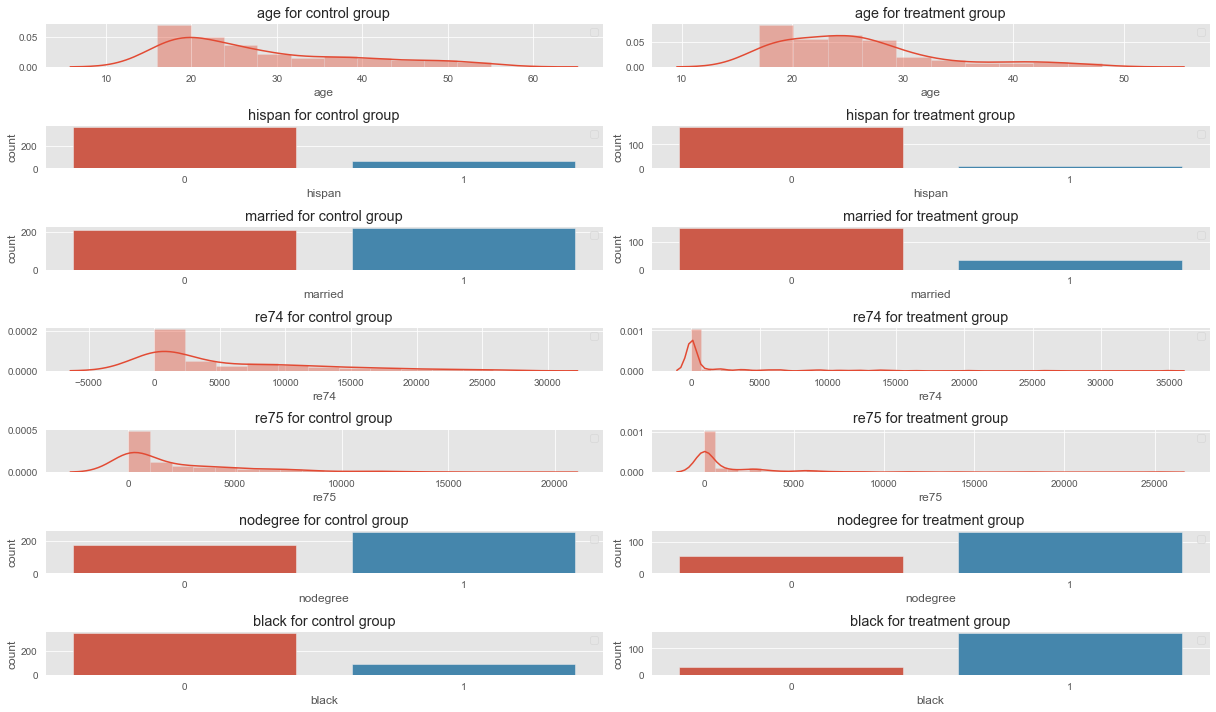

In [17]:
# nodegree
# black
# treat
plt.figure(figsize=(17,10))
cont = 0
for i, var in enumerate(["age","hispan","married","re74","re75","nodegree","black"]):    
    cont+=1
    plt.subplot(7,2,cont)
    if(var in ["age","re75","re74"]):
        sns.distplot(lalonde_df[controlGroup][var])
    else:        
        sns.countplot(data=lalonde_df[controlGroup], x=var)
    cont+=1
    plt.legend()
    plt.title("{} for control group".format(var))
    plt.subplot(7,2,cont)
    if(var in ["age","re75","re74"]):
        sns.distplot(lalonde_df[~controlGroup][var])
    else:
        sns.countplot(data=lalonde_df[~controlGroup], x=var)
    # sns.countplot(lalonde_df[~controlGroup]["treat"],label="Treatment")
    plt.legend()
    plt.title("{} for treatment group".format(var))

plt.tight_layout()

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3:

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

In [18]:
lalonde_df.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

In [19]:
lalonde_df['Intercept'] = 1
logit1 = sm.Logit(lalonde_df['treat'], lalonde_df[['Intercept','age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']]).fit()
logit1.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:                  0.3508
Time:                        19:02:50   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

---------

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

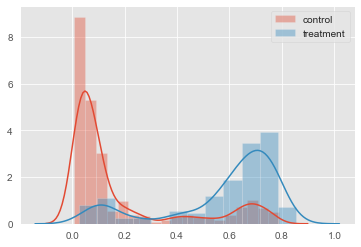

In [20]:
pscore_logit = logit1.predict()

sns.distplot(pscore_logit[controlGroup],label="control")
sns.distplot(pscore_logit[~controlGroup], label="treatment")
plt.legend()

In [21]:
lalonde_df["pscore"] = pscore_logit

---------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4:

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [22]:
treat_pscores = pscore_logit[~controlGroup].reshape(-1,1)
control_pscores = pscore_logit[controlGroup].reshape(-1,1)


In [24]:
knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean').fit(control_pscores)
knn

NearestNeighbors(metric='euclidean')

---------

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

In [25]:
nneighbors = knn.kneighbors(treat_pscores)

**Answer.**

---------

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

In [26]:
treatG = lalonde_df[~controlGroup]
treatG

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Intercept,pscore
NSW1,1,37,11,1,0,1,1,0.00,0.00,9930.0460,1,0.638770
NSW2,1,22,9,0,1,0,1,0.00,0.00,3595.8940,1,0.224634
NSW3,1,30,12,1,0,0,0,0.00,0.00,24909.4500,1,0.678244
NSW4,1,27,11,1,0,0,1,0.00,0.00,7506.1460,1,0.776324
NSW5,1,33,8,1,0,0,1,0.00,0.00,289.7899,1,0.701639
...,...,...,...,...,...,...,...,...,...,...,...,...
NSW181,1,33,12,1,0,1,0,20279.95,10941.35,15952.6000,1,0.287016
NSW182,1,25,14,1,0,1,0,35040.07,11536.57,36646.9500,1,0.149168
NSW183,1,35,9,1,0,1,1,13602.43,13830.64,12803.9700,1,0.494681
NSW184,1,35,8,1,0,1,1,13732.07,17976.15,3786.6280,1,0.507418


In [27]:
matchedControlG = lalonde_df[controlGroup].iloc[[val[0] for val in nneighbors[1]]]
matchedControlG

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Intercept,pscore
PSID69,0,30,17,1,0,0,0,17827.37000,5546.4190,14421.1300,1,0.638554
PSID111,0,51,11,0,0,0,1,48.98167,3813.3870,1525.0140,1,0.224079
PSID370,0,16,9,1,0,0,1,0.00000,0.0000,2158.9590,1,0.678789
PSID226,0,39,10,1,0,0,1,844.44400,889.7903,701.9201,1,0.778912
PSID140,0,19,9,1,0,0,1,1079.55600,2873.4680,14344.2900,1,0.705085
...,...,...,...,...,...,...,...,...,...,...,...,...
PSID239,0,18,11,0,1,0,1,0.00000,630.1935,0.0000,1,0.279756
PSID76,0,26,12,0,1,0,0,7968.33800,5109.5810,4181.9660,1,0.154729
PSID380,0,34,12,1,0,1,0,0.00000,0.0000,18716.8800,1,0.494177
PSID24,0,47,8,1,0,1,1,9275.16900,8543.4190,0.0000,1,0.508688


---------

### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5:

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.**

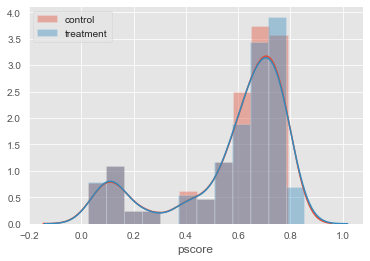

In [28]:
sns.distplot(matchedControlG["pscore"],label="control")
sns.distplot(treatG["pscore"],label="treatment")
plt.legend()

---------

### Exercise 6:

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

Now it totally changes, most of the variables are 

In [35]:
result = {}


for var in lalonde_df.columns:
    result[var]=  SMD(matchedControlG[var],treatG[var])
    

ASMD_df = pd.DataFrame([result]).melt()
ASMD_df["result"] = ASMD_df["value"].apply(lambda x: "balanced" if x < 0.1 else "Not too bad" if x < 0.2 else "imbalanced")
ASMD_df

,variable,value,result
0,treat,inf,imbalanced
1,age,0.203580,imbalanced
2,educ,0.013873,balanced
3,black,0.014725,balanced
4,hispan,0.022328,balanced
5,married,0.162509,Not too bad
6,nodegree,0.011826,balanced
7,re74,0.049934,balanced
8,re75,0.010219,balanced
9,re78,0.260313,imbalanced


In [47]:
def BalanceAssesment(matchedControlG,treatG):
    plt.figure(figsize=(17,10))
    cont = 0
    result = {}
    for i, var in enumerate(["age","hispan","married","re74","re75","re78","nodegree","black"]):    
        cont+=1
        plt.subplot(8,2,cont)
        result[var] = SMD(matchedControlG[var],treatG[var])
        if(var in ["age","re75","re74","re78"]):
            sns.distplot(matchedControlG[var])
        else:        
            sns.countplot(data=matchedControlG, x=var)
        cont+=1
        plt.legend()
        plt.title("{} for control group. SMD {}".format(var,result[var]))
        plt.subplot(8,2,cont)
        if(var in ["age","re75","re74","re78"]):
            sns.distplot(treatG[var])
        else:
            sns.countplot(data=treatG, x=var)
        # sns.countplot(lalonde_df[~controlGroup]["treat"],label="Treatment")
        plt.legend()
        plt.title("{} for treatment .  {}".format(var,result[var]))

    plt.tight_layout()


    ASMD_df = pd.DataFrame([result]).melt()
    ASMD_df["result"] = ASMD_df["value"].apply(lambda x: "balanced" if x < 0.1 else "Not too bad" if x < 0.2 else "imbalanced")
    return ASMD_df

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


,variable,value,result
0,age,0.203580,imbalanced
1,hispan,0.022328,balanced
2,married,0.162509,Not too bad
3,re74,0.049934,balanced
4,re75,0.010219,balanced
5,re78,0.260313,imbalanced
6,nodegree,0.011826,balanced
7,black,0.014725,balanced


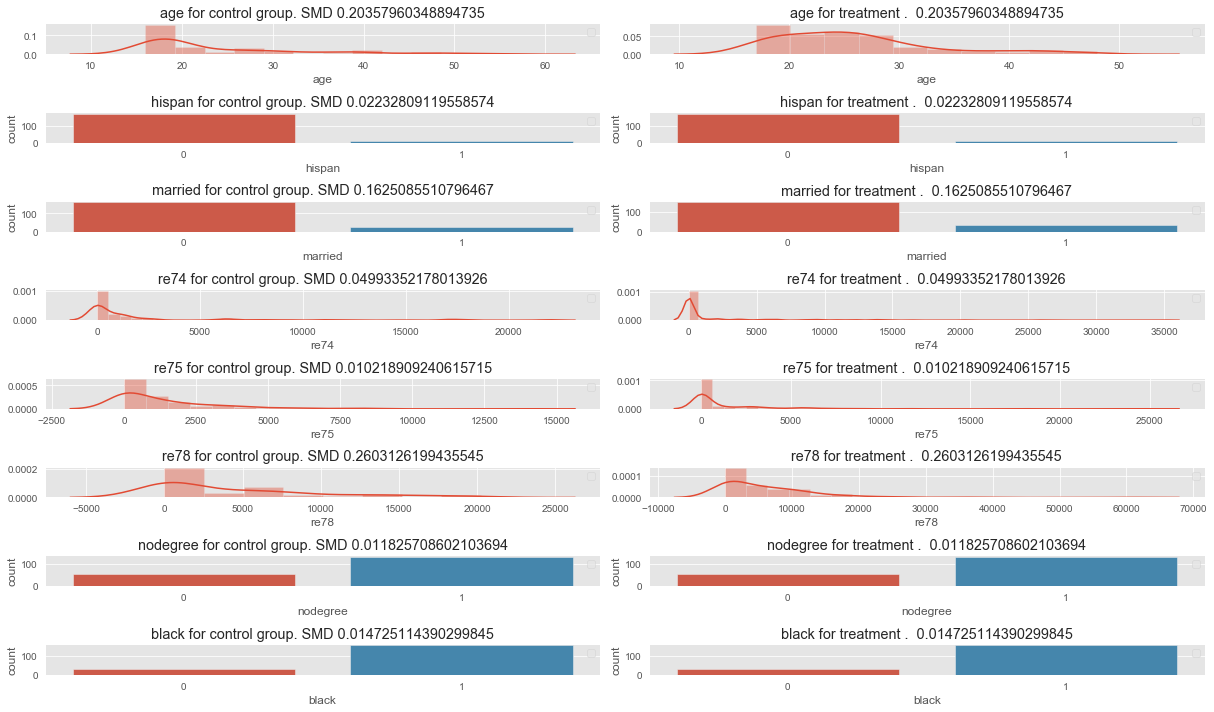

In [48]:
BalanceAssesment(matchedControlG,treatG)

---------

### Exercise 7:

Estimate the average effect of treatment on <font color='red'> wages (`re78`) </font> after matching. What do you conclude?

**Answer.**

In [38]:

decreaseIncomesControl = matchedControlG["re75"] > matchedControlG["re78"]
decreaseIncomesTreat = treatG["re75"] > treatG["re78"]
print("Percentage of control group people who saw a decrease in 1978 incomes are {:.3f}%" .format(sum(decreaseIncomesControl)/len(lalonde_df)*100))
print("Percentage of treatment group people who saw a decrease in 1975 incomes are {:.3f}%" .format(sum(decreaseIncomesTreat)/len(lalonde_df)*100))



print("Differences in mean from control repecto to treatment group is ${:.3f}" .format(matchedControlG["re78"].mean() - treatG["re78"].mean()))
print("Differences in median from control repecto to treatment is ${:.3f}" .format(matchedControlG["re78"].median() - treatG["re78"].median()))
# lalonde_df[controlGroup]
stats.ttest_ind(treatG["re78"],matchedControlG["re78"])



Percentage of control group people who saw a decrease in 1978 incomes are 9.446%
Percentage of treatment group people who saw a decrease in 1975 incomes are 4.886%
Differences in mean from control repecto to treatment group is $-1774.461
Differences in median from control repecto to treatment is $-2501.891


Ttest_indResult(statistic=2.5036066103570787, pvalue=0.012725784509926905)

---------

## Propensity score matching using decision trees and random forests

### Exercise 8:

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

In [39]:
clf2 = tree.DecisionTreeClassifier(max_depth = 4)

# Train Decision Tree Classifer
covariates=['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']

clf2 = clf2.fit(lalonde_df[covariates], lalonde_df['treat'])
# pscore_tree
pscore_tree = clf2.predict_proba(lalonde_df[covariates])[:,1]

---------

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**
blue


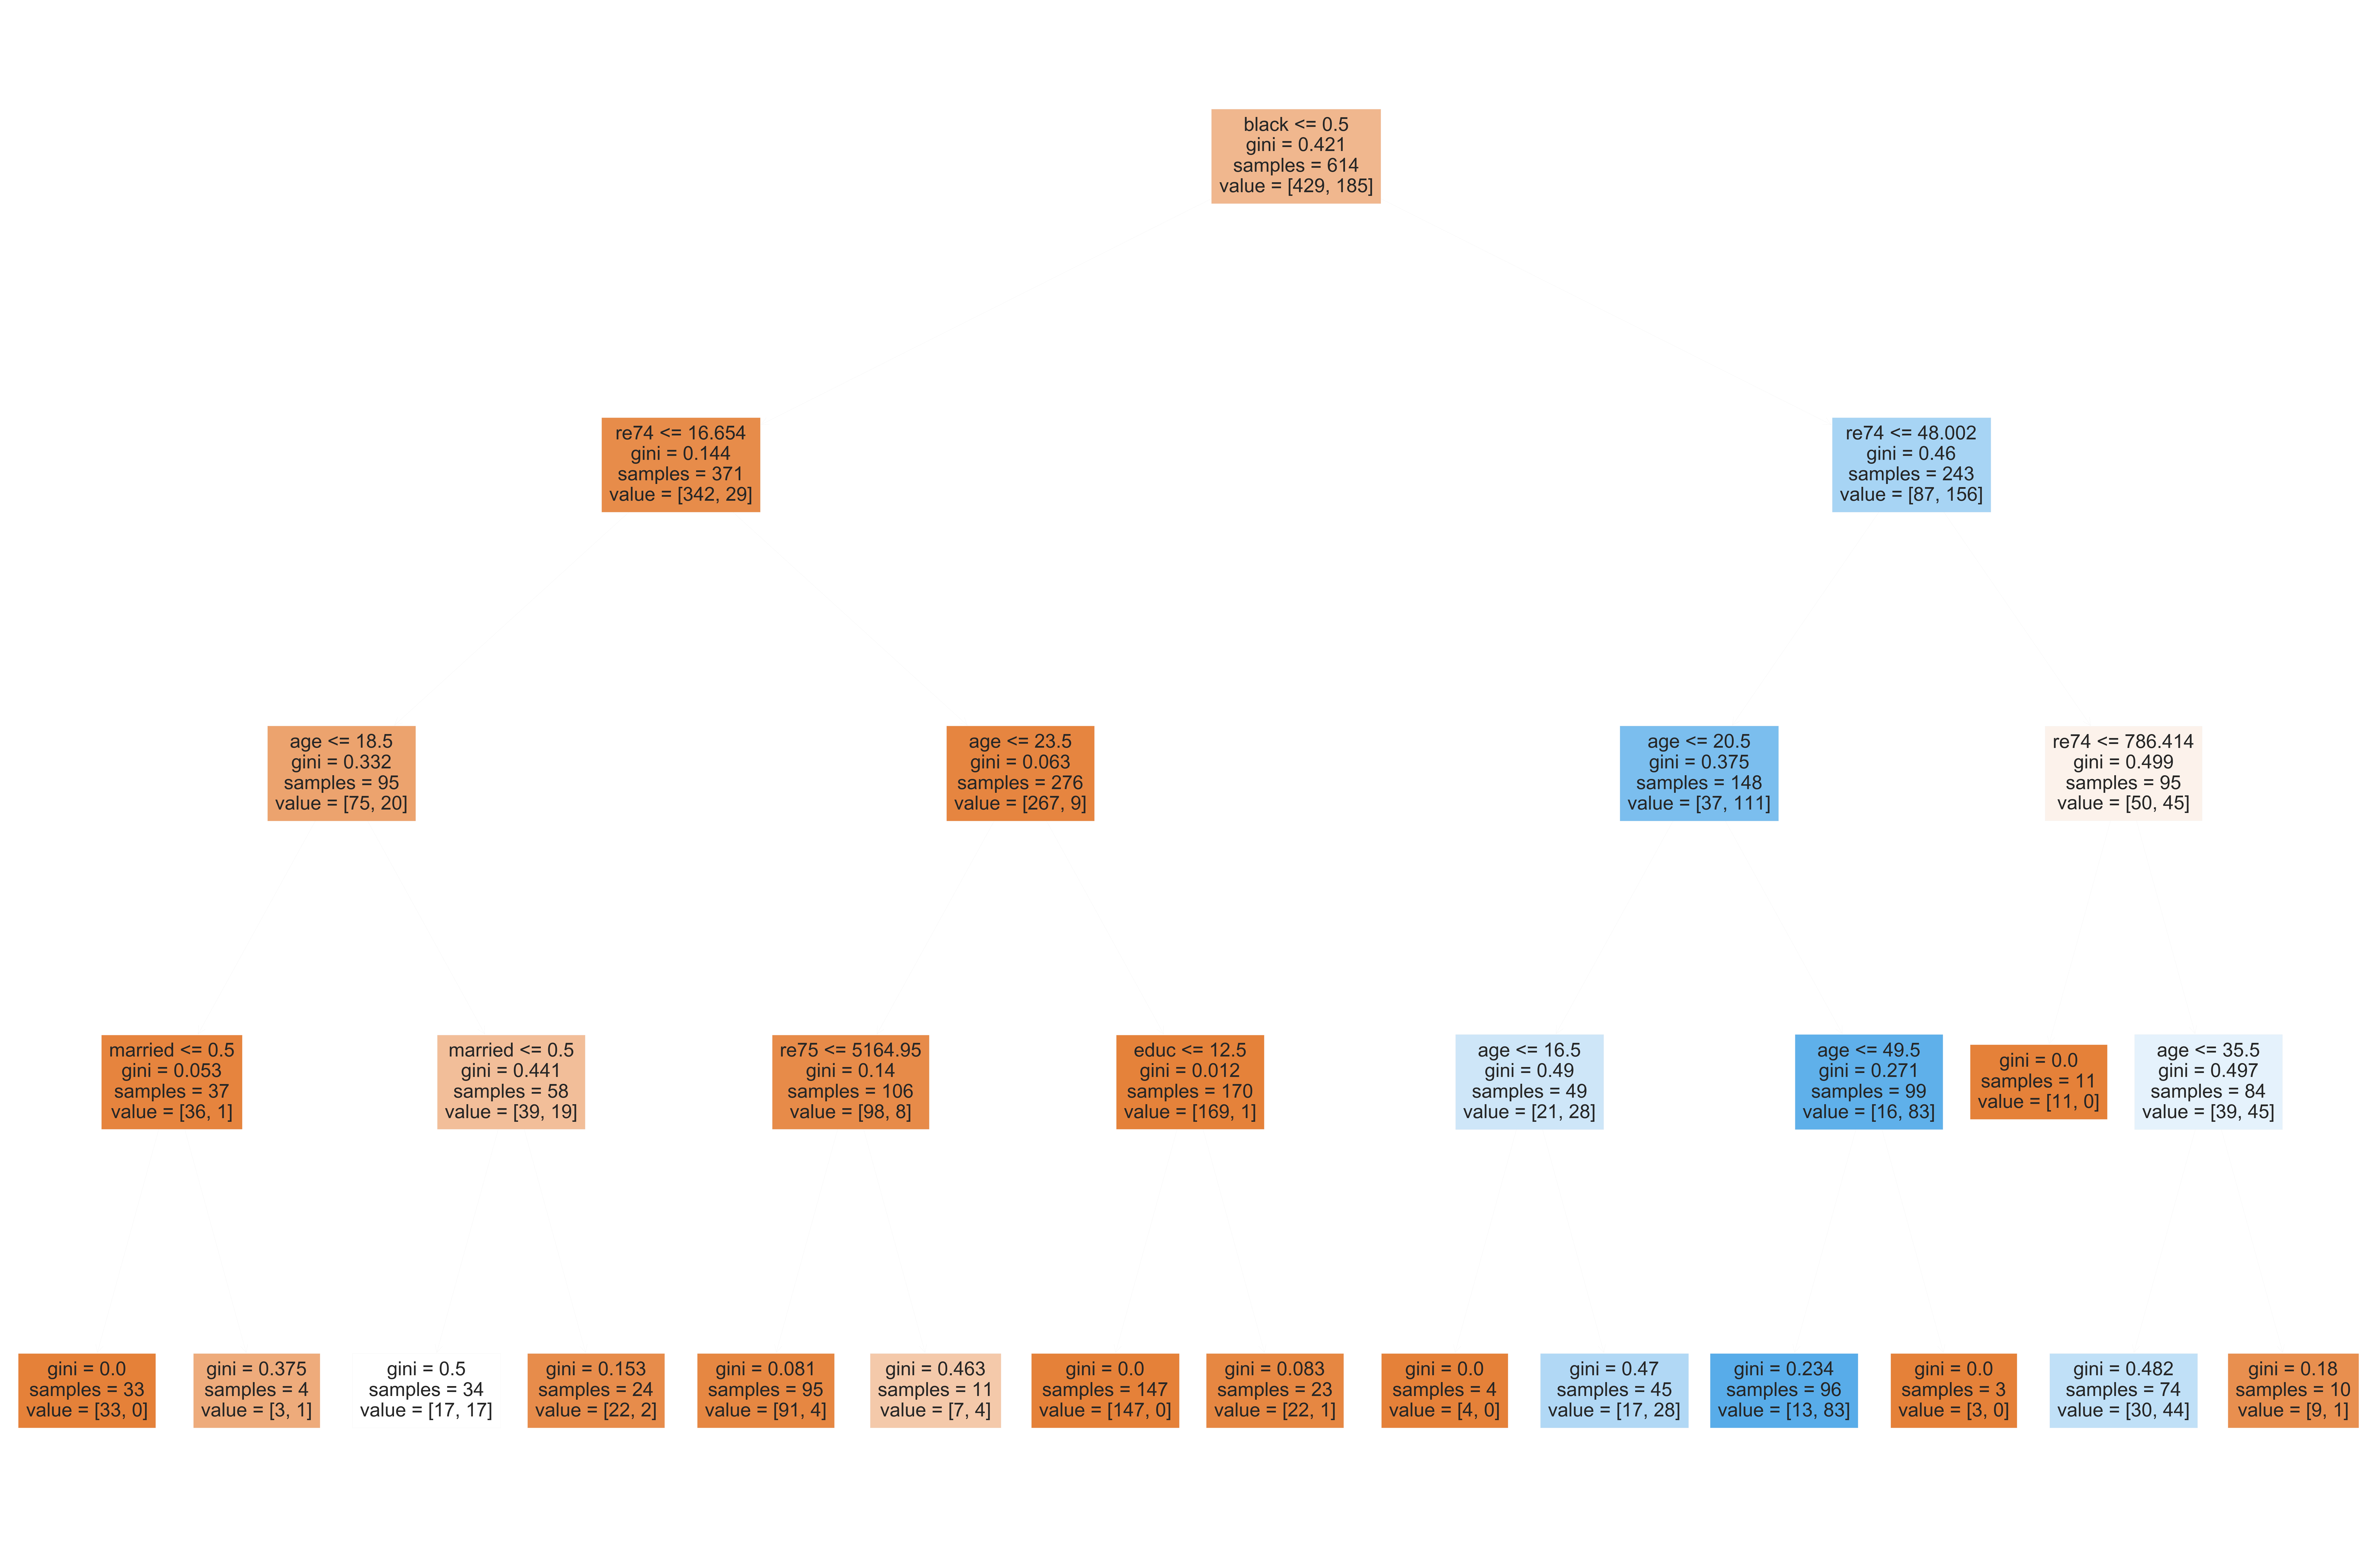

In [40]:

fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(clf2,filled=True,feature_names=covariates)
fig.savefig('tree.png')

---------

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

In [41]:
rfmodel = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42).fit(lalonde_df[covariates], lalonde_df['treat'])
pscore_forest = rfmodel.predict_proba(lalonde_df[covariates])[:,1]
pscore_forest

array([0.63329171, 0.38984631, 0.73535203, 0.75602973, 0.72852131,
       0.73416878, 0.72627266, 0.74397722, 0.64384568, 0.21431044,
       0.66277642, 0.70164953, 0.65007171, 0.68955017, 0.60754481,
       0.66308477, 0.72824021, 0.74106011, 0.71488408, 0.73535203,
       0.74695036, 0.27346354, 0.33648869, 0.753465  , 0.65900808,
       0.69879554, 0.75602973, 0.39908415, 0.64543868, 0.753465  ,
       0.64543868, 0.54614377, 0.6942122 , 0.64617169, 0.73535203,
       0.68549769, 0.70654861, 0.61425126, 0.54769889, 0.74757476,
       0.70876136, 0.27035427, 0.63650231, 0.27760067, 0.66838627,
       0.6942122 , 0.63650231, 0.64513033, 0.70654861, 0.72627266,
       0.74057382, 0.69879554, 0.65139098, 0.73535203, 0.69879554,
       0.64543868, 0.72534172, 0.53563112, 0.54061071, 0.35391784,
       0.63650231, 0.74057382, 0.73265305, 0.75602973, 0.65648613,
       0.74983114, 0.75602973, 0.32546085, 0.54954366, 0.72824021,
       0.74983114, 0.67775732, 0.61691905, 0.73535203, 0.67876

---------

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

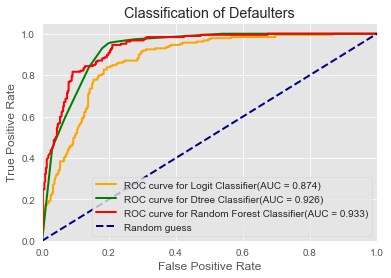

In [42]:
roc_logit = metrics.roc_curve(lalonde_df['treat'], pscore_logit)
roc_tree = metrics.roc_curve(lalonde_df['treat'], pscore_tree)
roc_forest = metrics.roc_curve(lalonde_df['treat'], pscore_forest)

auc_logit = metrics.auc( roc_logit[0], roc_logit[1] )
auc_tree = metrics.auc( roc_tree[0], roc_tree[1] )
auc_forest = metrics.auc( roc_forest[0], roc_forest[1] )

plt.figure()
line_width = 2

plt.plot(roc_logit[0], roc_logit[1], color='orange', lw=line_width,
         label=f"ROC curve for Logit Classifier(AUC = {auc_logit:0.3f})")
plt.plot(roc_tree[0], roc_tree[1], color='green', lw=line_width,
         label=f"ROC curve for Dtree Classifier(AUC = {auc_tree:0.3f})")
plt.plot(roc_forest[0], roc_forest[1], color='red', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_forest:0.3f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

---------

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

yes, since a higher AUC means that the model could achieve good predictions doesn't really means that it will get a better balance, desition trees for example has a very good AUC but a poor perfomance balancing covariates

---------

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

In [134]:

def matchingNeighbors(pscores):
    
    control_pscores = pscores[controlGroup].reshape(-1,1)
    treatment_pscores = pscores[~controlGroup].reshape(-1,1)
    print(len(treatment_pscores),len(control_pscores))
    knn_matching = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean').fit(control_pscores)
    values,idxs = knn_matching.kneighbors(treatment_pscores)
    
    return {"distances":values[:,0],"indexes":idxs[:,0]}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


185 429


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


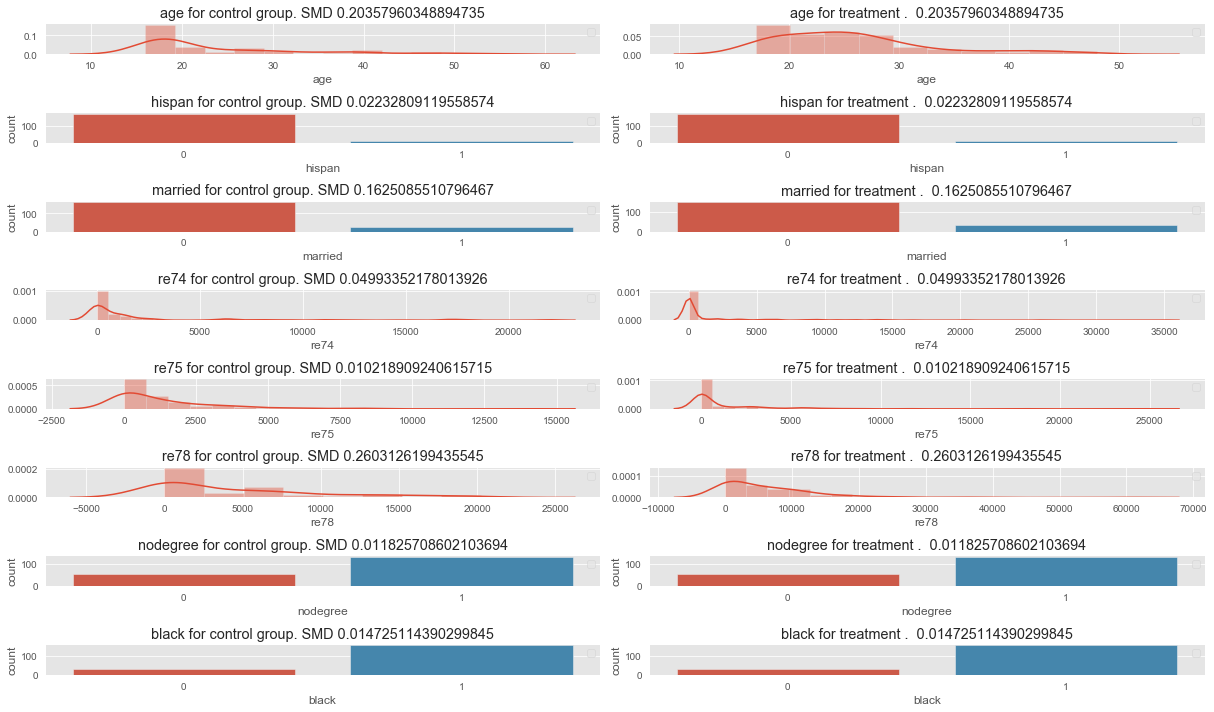

In [135]:
SMDs = []
distances = []
matchingResult_logit = matchingNeighbors(pscore_logit)
distances.append(pd.DataFrame(matchingResult_logit))
matchingControl_logit = lalonde_df[controlGroup].iloc[matchingResult_logit["indexes"]]
SMDs.append(BalanceAssesment(matchingControl_logit,treatG))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


185 429


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


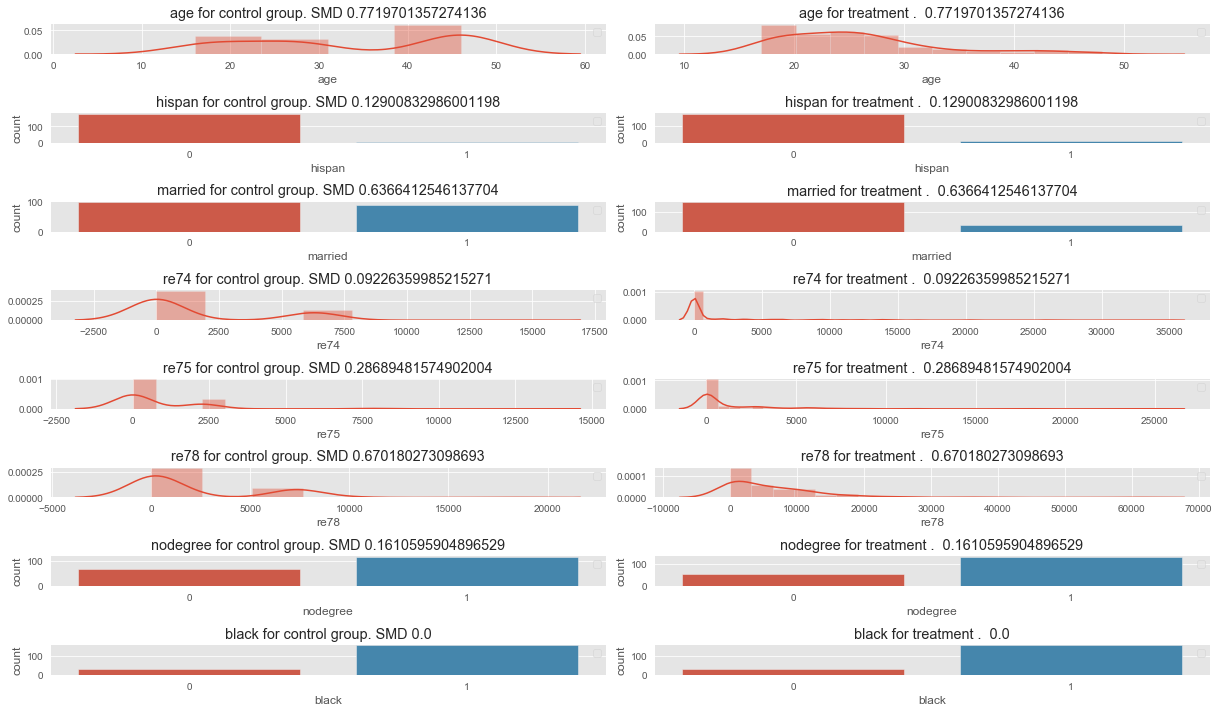

In [136]:
matchingResult_tree = matchingNeighbors(pscore_tree)
distances.append(pd.DataFrame(matchingResult_tree))
matchingControl_tree = lalonde_df[controlGroup].iloc[matchingResult_tree["indexes"]]
SMDs.append(BalanceAssesment(matchingControl_tree,treatG))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


185 429


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


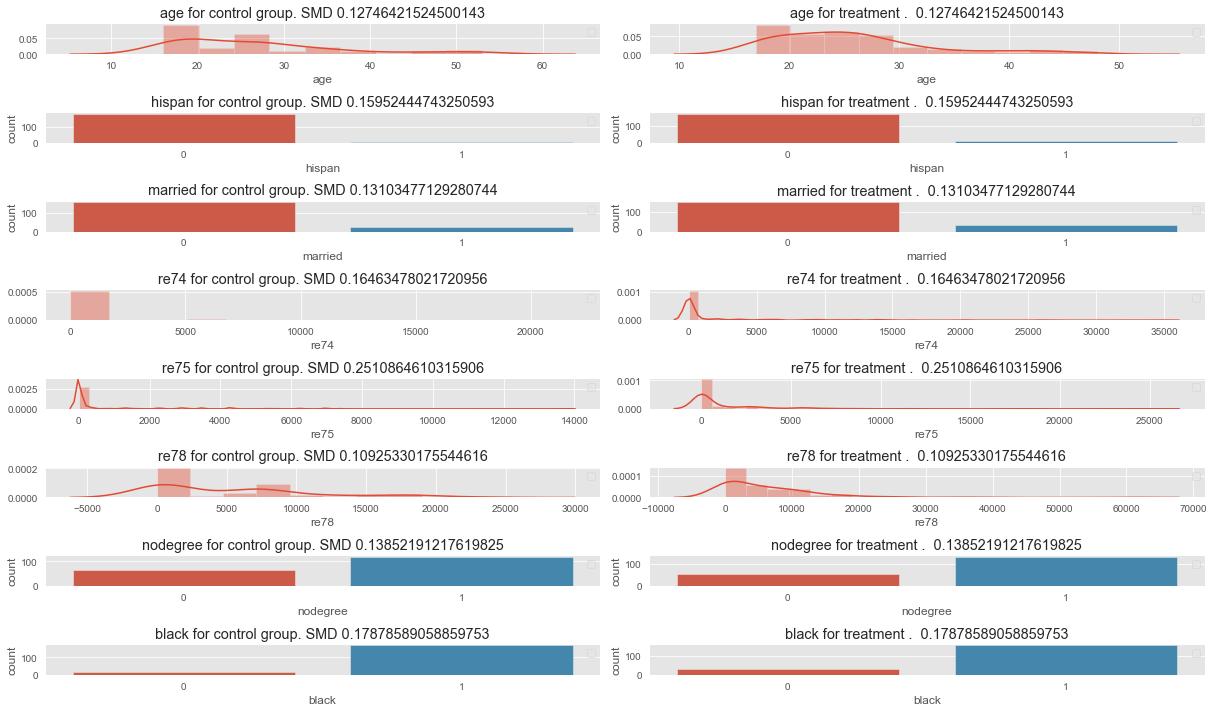

In [137]:
matchingResult_forest = matchingNeighbors(pscore_forest)
distances.append(pd.DataFrame(matchingResult_forest))
matchingControl_forest = lalonde_df[controlGroup].iloc[matchingResult_forest["indexes"]]
SMDs.append(BalanceAssesment(matchingControl_forest,treatG))

---------

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

Apparently trees proba is not very good to measure distences and eventually to balance the groups, it seems too verfit and most of the distances are 0 which leds to choose so many times the same few entries and it creates even more imbalanced features. It seems to be focused mainly to balance black feature maybe because it is the main feature choosen by the desition trees

In [138]:
pd.concat(SMDs,axis=1,keys=["logit","tree","forest"])

logit                             tree                           forest  \
   variable     value       result  variable     value       result  variable   
0       age  0.203580   imbalanced       age  0.771970   imbalanced       age   
1    hispan  0.022328     balanced    hispan  0.129008  Not too bad    hispan   
2   married  0.162509  Not too bad   married  0.636641   imbalanced   married   
3      re74  0.049934     balanced      re74  0.092264     balanced      re74   
4      re75  0.010219     balanced      re75  0.286895   imbalanced      re75   
5      re78  0.260313   imbalanced      re78  0.670180   imbalanced      re78   
6  nodegree  0.011826     balanced  nodegree  0.161060  Not too bad  nodegree   
7     black  0.014725     balanced     black  0.000000     balanced     black   

                          
      value       result  
0  0.127464  Not too bad  
1  0.159524  Not too bad  
2  0.131035  Not too bad  
3  0.164635  Not too bad  
4  0.251086   imbalanced  
5  0.109253  Not too bad  
6  0.138522  Not too bad  
7  0.178786  Not too bad

In [139]:
pd.concat(distances,axis=1,keys=["logit","tree","forest"])

logit              tree            forest        
    distances indexes distances indexes distances indexes
0    0.000216      68       0.0     407  0.000000     367
1    0.000555     110       0.0     404  0.000182      47
2    0.000545     369       0.0     407  0.014787     422
3    0.002587     225       0.0     407  0.005890     422
4    0.003446     139       0.0     407  0.012365     415
..        ...     ...       ...     ...       ...     ...
180  0.007261     238       0.0     158  0.000353      95
181  0.005561      75       0.0     158  0.007710     139
182  0.000504     379       0.0     158  0.009569     139
183  0.001270      23       0.0     158  0.001415      98
184  0.000078     268       0.0     158  0.002476     133

[185 rows x 6 columns]

---------

In [140]:
matchingNeighbors(pscore_tree)

185 429


{'distances': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'indexes': array([407, 404, 407, 407, 407, 407, 407, 407, 407, 287, 400, 407, 400,
        407, 400, 400, 407, 407, 407, 407, 407, 404, 404, 407, 400, 407,


In [141]:
matchingControl_tree.index.value_counts()

PSID408    83
PSID159    44
PSID401    28
PSID405    17
PSID270     4
PSID31      4
PSID288     2
PSID6       1
PSID391     1
PSID160     1
dtype: int64

In [131]:
matchingControl_tree.black.value_counts()

1    156
0     29
Name: black, dtype: int64

In [132]:
treatG.black.value_counts()

1    156
0     29
Name: black, dtype: int64